# Set up environment

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import os
import PIL.Image as Image
import numpy as np
import matplotlib.pyplot as plt
import requests

## Declare parameters

In [2]:
ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))

IMAGE_SIZE = 299
BATCH_SIZE = 32

## Enable GPU

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Running on", device)

Running on cuda:0


# Input model

## Declare model architecture

Currently supports:
    - inception_v3
    - mobilenet_v2
    - wide_resnet_101

In [4]:
MODEL_NAME = "wide_resnet_101"

## Fetch model architecture

In [5]:
print("Fetching model... ", end="")

# fetch feature extractor
if MODEL_NAME == "inception_v3":
    model = torchvision.models.inception_v3(pretrained=False)
elif MODEL_NAME == "mobilenet_v2":
    model = torchvision.models.mobilenet_v2(pretrained=False)
elif MODEL_NAME == "wide_resnet_101":
    model = torchvision.models.wide_resnet101_2(pretrained=False)

# replace classification head
if MODEL_NAME == "inception_v3":
    # handle auxilary net
    num_features = model.AuxLogits.fc.in_features
    model.AuxLogits.fc = torch.nn.Linear(num_features, 101)

    # handle primary net
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 101)
    
elif MODEL_NAME == "mobilenet_v2":
    num_features = model.classifier[1].in_features
    model.classifier[1] = torch.nn.Linear(num_features, 101)
    
elif MODEL_NAME == "wide_resnet_101":
    num_features = model.fc.in_features
    model.fc = torch.nn.Linear(num_features, 101)

model = model.to(device)
print("done")

Fetching model... done


## Load model weights

In [6]:
MODEL_PATH = os.path.join(ROOT_DIR, "models", "food_classification", MODEL_NAME, "fine_tuning.pt")

print("Loading learnt model weights...", end="")
model.load_state_dict(torch.load(MODEL_PATH))
print("done")

Loading learnt model weights...done


# Evaluate model on testing dataset

## Fetch test dataset

In [7]:
FOOD101_DIR = os.path.join(os.path.abspath(os.sep), "Datasets", "food101")
TEST_DIR = os.path.join(FOOD101_DIR, "test")

test_transform = transforms.Compose([
  transforms.Resize(IMAGE_SIZE),
  transforms.CenterCrop(IMAGE_SIZE),
  transforms.ToTensor(),
  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_raw = torchvision.datasets.ImageFolder(TEST_DIR, transform=test_transform)
test_loader = torch.utils.data.DataLoader(test_raw, batch_size=BATCH_SIZE)
test_size = len(test_raw)

class_names = test_raw.classes

## Define testing loop

In [8]:
def test(loss_func):
  model.eval()
  running_loss = 0.0
  running_corrects = 0

  for (images, labels) in test_loader:
    images = images.to(device)
    labels = labels.to(device)

    # fit images on model
    with torch.no_grad():
      outputs = model(images)
      _, predictions = torch.max(outputs, 1)
      loss = loss_func(outputs, labels)

    running_loss += loss.item() * images.size(0)
    running_corrects += torch.sum(predictions == labels.data)

  # calculate statistics
  loss = running_loss / test_size
  acc = running_corrects.double() / test_size

  return loss, acc

## Run testing

In [9]:
loss_func = torch.nn.CrossEntropyLoss()
loss, acc = test(loss_func)

acc

tensor(0.8476, device='cuda:0', dtype=torch.float64)

# Show inference on batch of test images

In [10]:
def predict(images):
    images = images.to(device)
    model.eval()
    
    with torch.no_grad():
        outputs = model(images)
        _, predictions = torch.max(outputs, 1)
    
    return [class_names[i] for i in predictions]

# randomly select 20 images from validation set
images = []
real_classes = []
for i in range(20):
    j = np.random.randint(test_size)
    img, lbl = test_raw[j]
    images.append(img.numpy())
    real_classes.append(class_names[lbl])

inputs = torch.tensor(images)
predicted_classes = predict(inputs)

## Show estimated classes against real

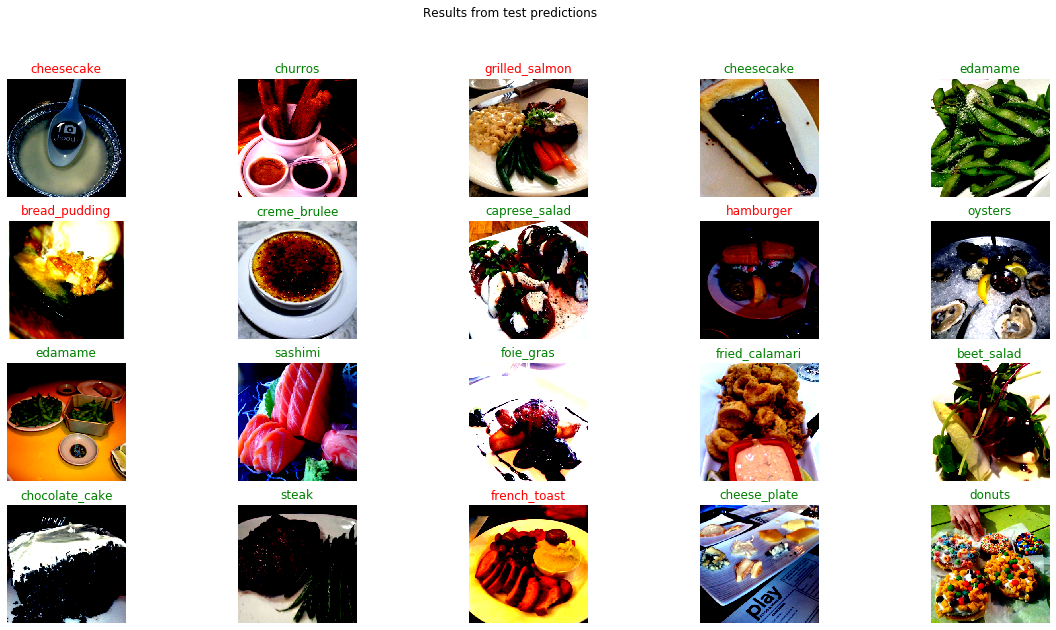

In [11]:
cols, rows = 5, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle("Results from test predictions")

for i in range(1, cols*rows+1):
  fig.add_subplot(rows, cols, i)

  # randomly sellect image from dataset
  img = images[i-1]
  img = np.transpose(img, (1,2,0))
  img = img * (0.485, 0.456, 0.406) + (0.229, 0.224, 0.225)

  # display title as green if correct otherwise red
  color = "green" if predicted_classes[i-1] == real_classes[i-1] else "red"
  plt.title(predicted_classes[i-1], color=color)
  plt.axis("off")
  img = np.clip(img, 0, 1)
  plt.imshow(img, interpolation="nearest")
plt.show()